# Visualizing DINO attention maps

In this notebook, we visualize the attention maps learned in DINO 🦖. DINO was proposed in [Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/abs/2104.14294). 

Some of the utilities shown in this notebook come from the [official DINO codebase](https://github.com/facebookresearch/dino/).

In [1]:
!pip install transformers -q

We start by writing a utility for loading images from URLs.

In [2]:
import requests
from PIL import Image
from io import BytesIO

import requests
from PIL import Image
from io import BytesIO


def load_image_from_url(url):
    """Load an image from a given URL."""
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return image

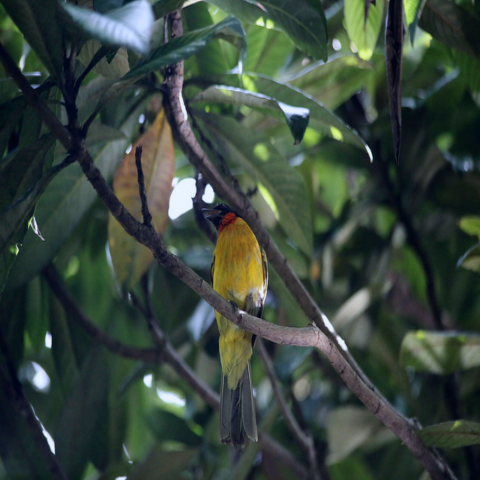

In [3]:
image = load_image_from_url("https://dl.fbaipublicfiles.com/dino/img.png")
image

Next, we write a utility to load a DINO checkpoint using 🤗 Transformers. We also load its corresponding processor class which is just a convenience class for performing preprocessing ops. 

For this notebook, we default to the ["facebook/dino-vitb16"](https://hf.co/facebook/dino-vitb16) checkpoint but one can find all the other DINO checkpoints [here](https://huggingface.co/models?search=dino&author=facebook). 

In [4]:
from transformers import AutoImageProcessor, ViTModel
import torch


def load_ckpt(ckpt_id="facebook/dino-vitb16"):
    """Loads a pretrained model along with its processor class."""
    image_processor = AutoImageProcessor.from_pretrained(ckpt_id)
    model = ViTModel.from_pretrained(ckpt_id).eval()
    return model, image_processor

Our next utility extracts the attention scores by running the model on an input image. 

In [5]:
def get_attention_scores(image: Image, model: torch.nn.Module, processor):
    """Extracts attention scores given an image, a model,
    and its processor."""
    inputs = processor(image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    return outputs.attentions

Let's investigate the shape of attention scores from the first transformer block of our DINO model. 

In [6]:
ckpt_id = "facebook/dino-vitb16"

model, processor = load_ckpt(ckpt_id)
block_id = 0
attention_scores = get_attention_scores(image, model, processor)
print(attention_scores[block_id].shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 12, 197, 197])


We have 12 attention heads in each transformer blocks. Since the model uses a patch size of 16x16 and an image size of 224x224 we have 196 patches in total. It becomes 197 when we add the CLS token.

Next, we process the attention maps such that they can be visualized. This utility is referred from the [official codebase](https://github.com/facebookresearch/dino/). 

In [7]:
from torchvision.transforms import functional as F


def process_attention_map(
    image: torch.Tensor, attention_scores, block_id=11, patch_size=16
):
    """
    Processes the attention scores such that they can be overlaid on the input image.

    Args:
        image (torch.Tensor): The input image tensor.
        attention_scores (Tuple[torch.Tensor]): Tuple of attention scores.
        block_id (int, optional): The block ID. Default is 11. 11 is the last
            transformer block for a DINO base model.
        patch_size (int, optional): The size of the patches. Default is 16.

    Returns:
        numpy.ndarray: The processed attention map as a NumPy array.
    """
    height, width = image.shape[2:]
    w_featmap = width // patch_size
    h_featmap = height // patch_size

    num_heads = attention_scores[block_id].shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[block_id][0, :, 0, 1:].reshape(num_heads, -1)
    print(attentions.shape)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    print(attentions.shape)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = F.resize(
        attentions, size=(h_featmap * patch_size, w_featmap * patch_size)
    )
    print(attentions.shape)
    return attentions.numpy()

Next, we write a utility for visualizing the processed attention maps. 

In [8]:
import matplotlib.pyplot as plt
import re


def visualize_attn_maps(image, processor, model, ckpt_id, block_id=11):
    """Visualizes the processed attention map. It also returns the
    processed attention map."""
    attention_scores = get_attention_scores(image, model, processor)

    patch_size = int(re.search(r"\d+", ckpt_id).group())
    preprocessed_image = processor(image, return_tensors="pt")["pixel_values"]
    processed_attention_map = process_attention_map(
        preprocessed_image, attention_scores, block_id=11, patch_size=patch_size
    )

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
    img_count = 0

    for i in range(3):
        for j in range(4):
            if img_count < len(processed_attention_map):
                axes[i, j].imshow(processed_attention_map[img_count])
                axes[i, j].title.set_text(f"Attention head: {img_count + 1}")
                axes[i, j].axis("off")
                img_count += 1

    fig.tight_layout()
    plt.show()

    return processed_attention_map

torch.Size([12, 196])
torch.Size([12, 14, 14])
torch.Size([12, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


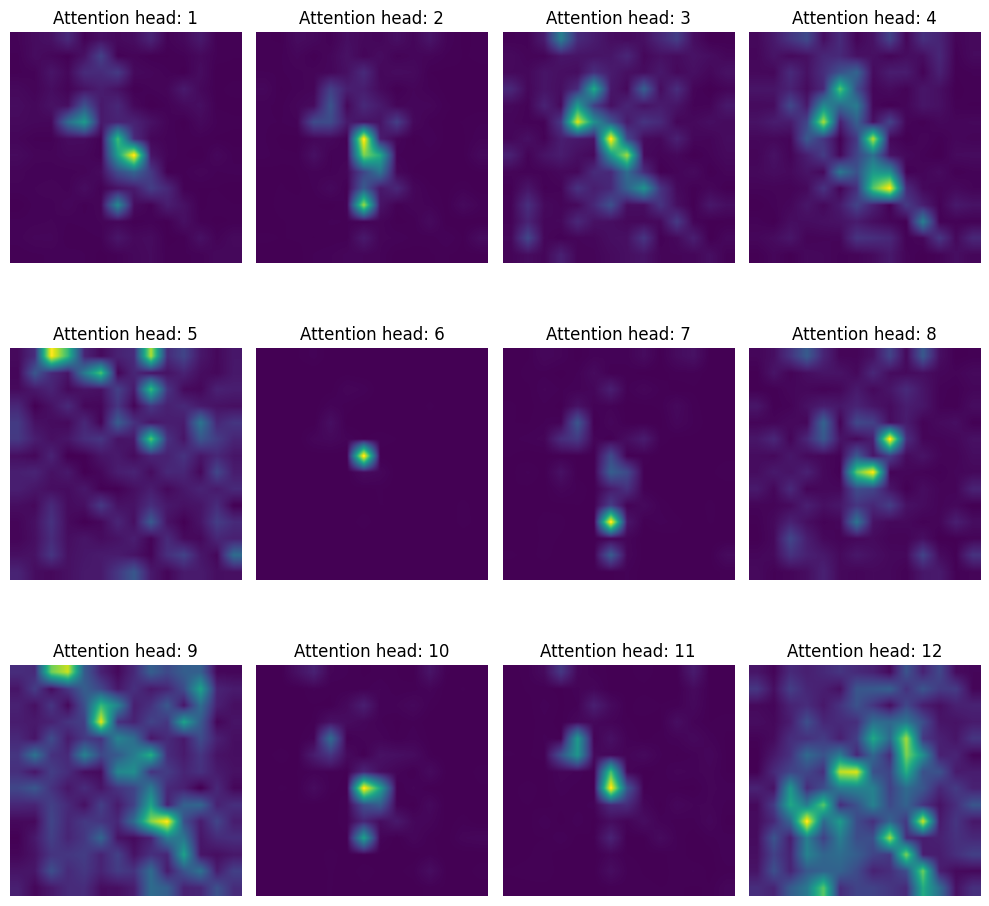

In [9]:
processed_attention_map = visualize_attn_maps(
    image, processor, model, ckpt_id, block_id=11
)

We can also plot an aggregated attention map summing over the indvidual attention maps from all the attention heads. 

In [10]:
def show_agg_attention_map(processed_attention_map):
    aggregated_attention_map = sum(
        processed_attention_map[i] * 1 / processed_attention_map.shape[0]
        for i in range(processed_attention_map.shape[0])
    )

    plt.imshow(aggregated_attention_map, cmap="inferno")
    plt.axis("off")
    plt.show()

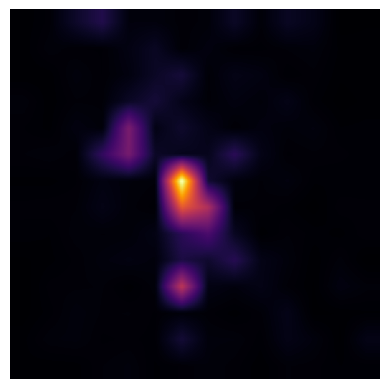

In [11]:
show_agg_attention_map(processed_attention_map)

We can also visualize how the attention maps look like for a different DINO checkpoint. 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([12, 784])
torch.Size([12, 28, 28])
torch.Size([12, 224, 224])


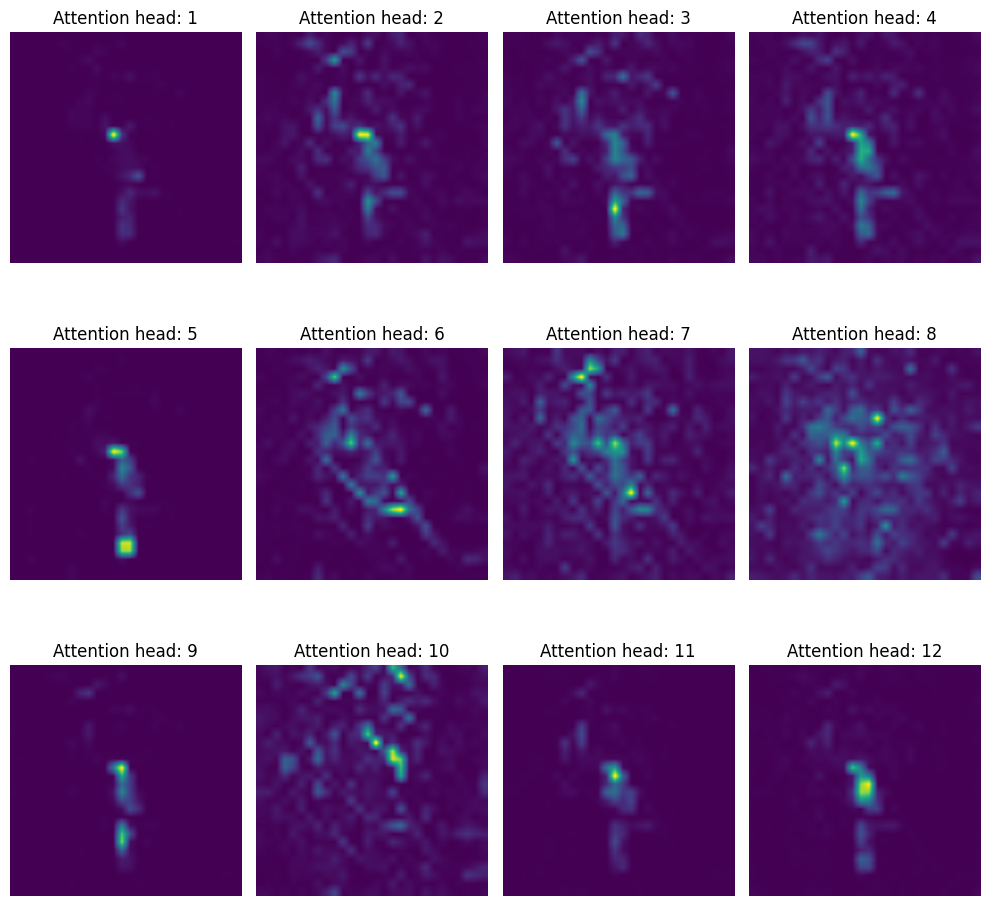

In [12]:
ckpt_id = "facebook/dino-vitb8"

model, processor = load_ckpt(ckpt_id)
processed_attention_map = visualize_attn_maps(
    image, processor, model, ckpt_id, block_id=11
)

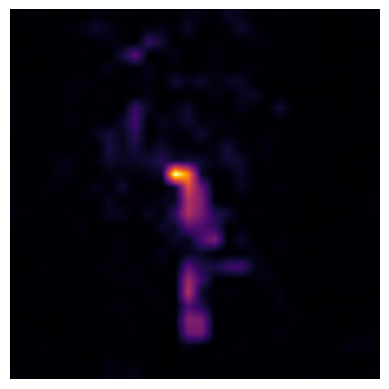

In [13]:
show_agg_attention_map(processed_attention_map)